 # Installing Libraris

In [1]:
! pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 11.6 MB/s eta 0:00:00


# Libraries

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import re
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input,Flatten,Embedding, Dropout,Conv1D,MaxPooling1D, Dense, GlobalMaxPooling1D,BatchNormalization, Add,GlobalAveragePooling1D
from tensorflow.keras.models import Model
from reportlab.lib.pagesizes import letter
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.platypus import SimpleDocTemplate, Paragraph, Image, Spacer
from tensorflow.keras.applications import VGG16

2024-05-02 03:43:01.953375: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 03:43:01.953487: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 03:43:02.113238: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Setup Stop Words

In [3]:
stop_words = set(stopwords.words('english'))

# Functions for our model

## Load Data

In [4]:
def load_data():
    df=pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv',encoding='latin1')
    print(df.columns)
    print(df.head())
    return df

## Extract text

In [5]:
def extract_sentences(df):
    df.drop(["1467810369","Mon Apr 06 22:19:45 PDT 2009","NO_QUERY","_TheSpecialOne_"],axis=1,inplace=True)
    df.columns=['Class','tweets']
    print(df.head())
    return df

In [6]:
def prepare_Classes(df):
    y=df['Class']
    y[y==4]=1
    return y

In [7]:
def check_stopwords(sentence):
    final_sentence=[]
    for word in sentence.split():
        if word not in stop_words:
            final_sentence.append(word)
    return final_sentence

## Sentence preprocessing

In [8]:
def clean_sentences(sentence):
    sentence = re.sub(r"https?://\S+|www\.\S+"," ",sentence)#for urls
    sentence = re.sub(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});"," ",sentence)#html tags
    sentence = re.sub(r"[^\w\s]", " ", sentence)# Removing the Punctuation
    sentence = re.sub(r"\w*\d\w*", " ", sentence)# Removing words that have numbers
    sentence = re.sub(r"[0-9]+", " ", sentence)# Removing Digits
    sentence = re.sub(r"\s+", " ", sentence).strip() # Cleaning white spaces
    sentence = sentence.lower()
    Words=check_stopwords(sentence)
    return " ".join(Words)

## Split Data

In [9]:
def split_data(data,output):
    X_train,X_test,y_train,y_test=train_test_split(data['tweets'],output,test_size=0.2,random_state=42)
    print('\n')
    print('Train shape',X_train.shape)
    print('Y_Train',y_train.shape)
    print('Test shape',X_test.shape)
    print('Y_Test shape',y_test.shape)
    print('\n')
    return X_train,X_test,y_train,y_test

## Tokenization

In [10]:
def tokenize_data(X_train,X_test,max_words):
    tokenizer= Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train)
    sequence_X_train = tokenizer.texts_to_sequences(X_train)
    sequence_X_test = tokenizer.texts_to_sequences(X_test)
    return sequence_X_train, sequence_X_test, tokenizer

In [11]:
def get_vocab_length(tokenizer):
    vocab = tokenizer.word_index
    vocab_length = len(vocab)
    return vocab_length

## Padding

In [12]:
def padding(train_sequences, test_sequences):
    padded_X_train=pad_sequences(train_sequences)
    max_lenght=padded_X_train.shape[1]
    padded_X_test=pad_sequences(test_sequences,maxlen=max_lenght)
    print(f"After padding: {padded_X_train.shape}")
    print(f"After padding:{padded_X_test.shape}")
    return padded_X_train, padded_X_test, max_lenght

## Plot

In [13]:
def plot_model(model, model_number):
    tf.keras.utils.plot_model(model, to_file=f'model_plot{model_number}.png', show_shapes=True, show_layer_names=True)
    img = mpimg.imread(f'/kaggle/working/model_plot{model_number}.png')
    plt.figure(figsize=(11, 15))  
    plt.imshow(img)
    plt.axis('off')  
    plt.show()

In [14]:
def plot_history(history, save_path=None):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    
    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

# Model

## CNN Model

In [15]:
def build_cnn_model(model_index, model_parameters, max_length, vocab_length, window=3, dim=40):
    INPUT = Input((max_length,))
    x = Embedding((vocab_length + 1), dim)(INPUT)
    x = Conv1D(32, window, activation='relu')(x)
    x = MaxPooling1D(3)(x)
    x = Conv1D(64, window, activation='relu')(x)
    x = MaxPooling1D(3)(x)
    x = Conv1D(128, window, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(INPUT, x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_parameters[model_index] = [dim, window, 32, 64, 128]
    plot_model(model, model_index)
    return model

## VGG Model

In [16]:
def build_vgg_model_for_text(model_index, model_parameters, max_length, vocab_length):
    INPUT = Input(shape=(max_length,))
    x = Embedding(vocab_length + 1, 128)(INPUT)
    x = Conv1D(64, 3, padding='same', activation='relu')(x)
    x = Conv1D(64, 3, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)
    x = Conv1D(128, 3, padding='same', activation='relu')(x)
    x = Conv1D(128, 3, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)
    x = Conv1D(256, 3, padding='same', activation='relu')(x)
    x = Conv1D(256, 3, padding='same', activation='relu')(x)
    x = Conv1D(256, 3, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)
    x = Conv1D(512, 3, padding='same', activation='relu')(x)
    x = Conv1D(512, 3, padding='same', activation='relu')(x)
    x = Conv1D(512, 3, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dense(4096, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(INPUT, output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Storing architecture parameters
    model_parameters[model_index] = "VGG for text"
    
    plot_model(model, model_index)
    return model

## Resnet Model

In [17]:
def build_resnet_model(model_index, model_parameters, max_length, vocab_length, filters=64, kernel_size=3, num_blocks=3):
    INPUT = Input((max_length,))
    x = Embedding((vocab_length + 1), 128)(INPUT)
    x = Conv1D(filters, kernel_size, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    for _ in range(num_blocks):
        shortcut = x
        x = Conv1D(filters, kernel_size, padding='same', activation='relu')(x)
        x = Conv1D(filters, kernel_size, padding='same')(x)
        x = Add()([x, shortcut])
        x = BatchNormalization()(x)
        x = MaxPooling1D(pool_size=2)(x)
    
    x = GlobalAveragePooling1D()(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model = Model(INPUT, x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Storing architecture parameters
    model_parameters[model_index] = {'filters': filters, 'kernel_size': kernel_size, 'num_blocks': num_blocks}
    
    plot_model(model, model_index)
    return model

# Trainning 

In [18]:
def fitting_models(models, padded_sequences_train, y_train, padded_sequences_test, y_test):
    for i, model in enumerate(models):
        print(f"\nModel {i+1}:")
        history = model.fit(padded_sequences_train, y_train, validation_data=(padded_sequences_test, y_test), epochs=10, batch_size=64)
        plot_history(history, save_path=f"Model_history_{i+1}.png")

# PDF

In [19]:
def generate_results_pdf(model_parameters):
    # Create a PDF document
    doc = SimpleDocTemplate("Results.pdf", pagesize=letter)

    # Define the styles for the document
    styles = getSampleStyleSheet()

    # Create a list to store the PDF components
    pdf_components = []

    # Iterate over each model parameter in the dictionary
    for i, model_parameter in model_parameters.items():
        
        # Create a heading for the model
        heading1 = Paragraph(f"Model {i}:", styles["Heading1"])
        
        # Create a paragraph with the model parameters
        if isinstance(model_parameter, list):
            text = f"Parameters: Embedding dimension = {model_parameter[0]}, Window = {model_parameter[1]}, 1- Conv1D no. filters = {model_parameter[2]}, 2- Conv1D no. filters = {model_parameter[3]} 3- Conv1D no. filters = {model_parameter[4]}"
        else:
            text = f"Architecture: {model_parameter}"
        para1 = Paragraph(text, styles["Normal"])
        
        # Load and add the model plot image to the PDF components
        img = Image(f"model_plot{i}.png", width=300, height=600)
        pdf_components += [heading1] + [Spacer(1, 30)] + [para1] + [Spacer(1, 30)] + [img]

        # Load and add the model history plot image to the PDF components
        acc = Image(f"Model_history_{i}.png", width=200, height=200)
        pdf_components += [Spacer(1, 30)] + [acc] + [Spacer(1, 30)] 
        
    # Create a heading for the Conclusion
    heading2 = Paragraph("Conclusion:")
    
    # Conclusion paragraph
    text = "According to the accuracies of each architecture, it appears that the first one one outperforms the others."
    para2 = Paragraph(text, styles["Normal"])

    # Build the PDF document with the components
    doc.build(pdf_components + [heading2] + [para2])


# Run

In [20]:
def run():
    # Load the data
    df = load_data()

    # Extract the data from the loaded dataframe
    df = extract_sentences(df)
    
    # Clean the data
    df.loc[:, 'tweets'] = df['tweets'].apply(clean_sentences)

    # Convert the labels to numerical values
    y = prepare_Classes(df)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = split_data(df, y)

    # Clean and tokenize the text data
    sequence_X_train, sequence_X_test, tokenizer = tokenize_data(X_train, X_test, 15000)

    # Get the vocabulary length
    vocab_length = get_vocab_length(tokenizer)

    # Pad the sequences to have the same length
    padded_sequences_train, padded_sequences_test, max_length = padding(sequence_X_train, sequence_X_test)

    # Build and train the models
    model_parameters = {}
    models = [
        build_cnn_model(1, model_parameters, max_length, vocab_length, dim=20, window=3),
        build_cnn_model(2, model_parameters, max_length, vocab_length, dim=30, window=4),
        build_resnet_model(3, model_parameters, max_length, vocab_length, filters=64, kernel_size=3, num_blocks=3),
        build_vgg_model_for_text(4, model_parameters, max_length, vocab_length)
    ]
    fitting_models(models, padded_sequences_train, y_train, padded_sequences_test, y_test)

    # Generate the results PDF
    generate_results_pdf(model_parameters)

Index(['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY',
       '_TheSpecialOne_',
       '@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D'],
      dtype='object')
   0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY _TheSpecialOne_  \
0  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   scotthamilton   
1  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY        mattycus   
2  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY         ElleCTF   
3  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          Karoli   
4  0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY        joy_wolf   

  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  
0  is upset that he can't update his Facebook by ...                                                                   
1  @Kenichan I dived many times for the ball. Man...      

/tmp/ipykernel_25/2547874118.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y==4]=1




Train shape (1279999,)
Y_Train (1279999,)
Test shape (320000,)
Y_Test shape (320000,)


After padding: (1279999, 116)
After padding:(320000, 116)


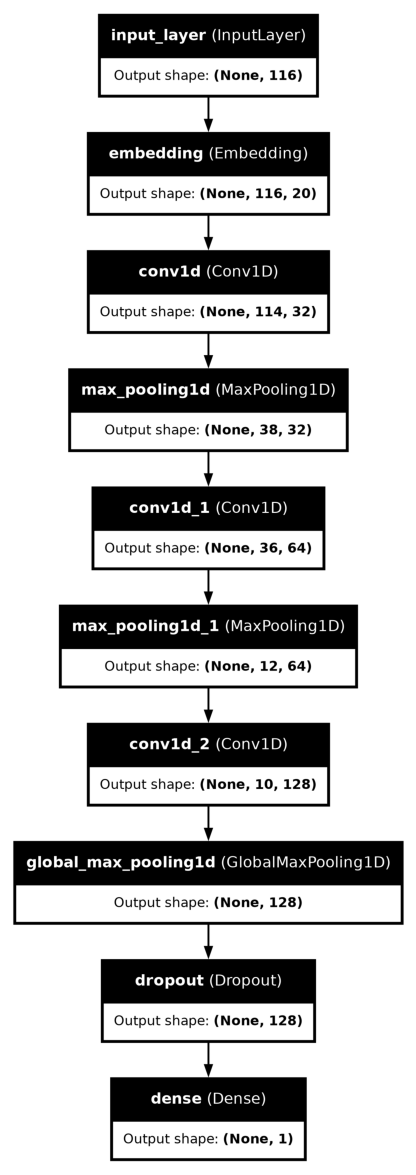

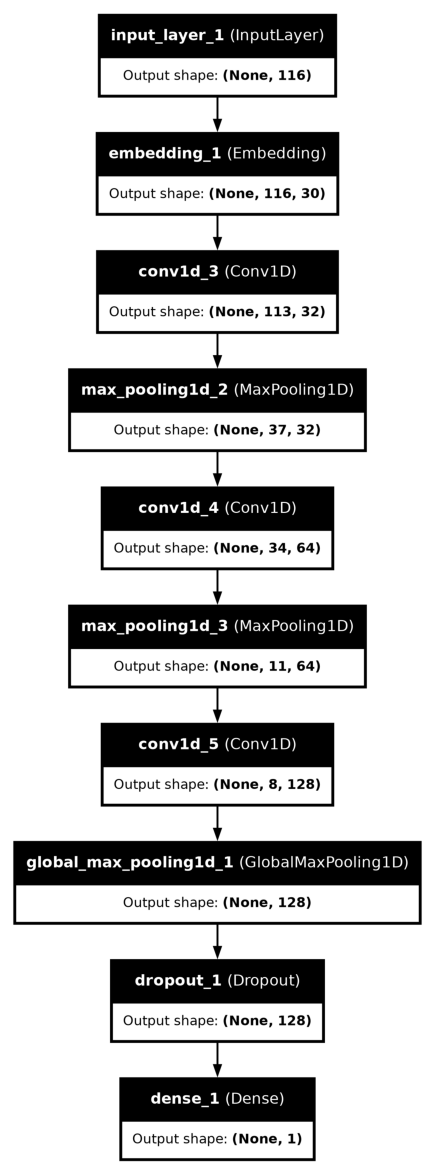

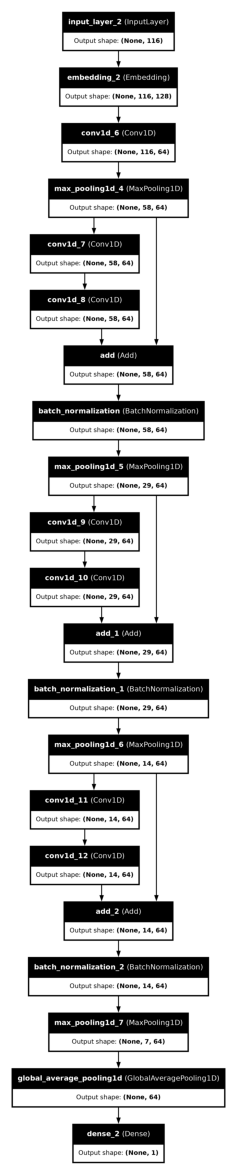

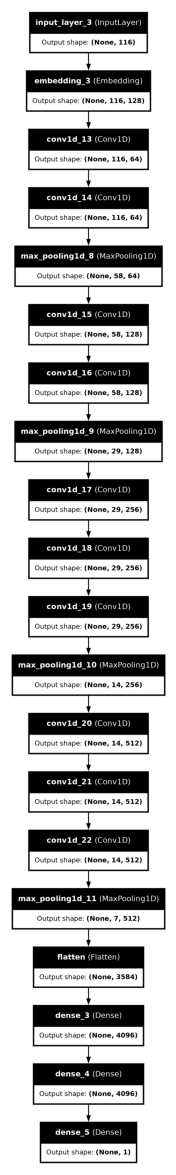


Model 1:
Epoch 1/10
   30/20000 ━━━━━━━━━━━━━━━━━━━━ 1:49 5ms/step - accuracy: 0.4890 - loss: 0.6936

I0000 00:00:1714621535.110662      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 109s 5ms/step - accuracy: 0.7560 - loss: 0.4964 - val_accuracy: 0.7840 - val_loss: 0.4547
Epoch 2/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 99s 5ms/step - accuracy: 0.7934 - loss: 0.4430 - val_accuracy: 0.7868 - val_loss: 0.4508
Epoch 3/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 99s 5ms/step - accuracy: 0.8040 - loss: 0.4236 - val_accuracy: 0.7859 - val_loss: 0.4537
Epoch 4/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 99s 5ms/step - accuracy: 0.8110 - loss: 0.4109 - val_accuracy: 0.7841 - val_loss: 0.4599
Epoch 5/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 99s 5ms/step - accuracy: 0.8187 - loss: 0.3975 - val_accuracy: 0.7832 - val_loss: 0.4648
Epoch 6/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 100s 5ms/step - accuracy: 0.8233 - loss: 0.3887 - val_accuracy: 0.7803 - val_loss: 0.4740
Epoch 7/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 100s 5ms/step - accuracy: 0.8279 - loss: 0.3802 - val_accuracy: 0.7771 - val_loss: 0.4783
Epoch 8/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 100s 5ms/step - accuracy: 0.8314 

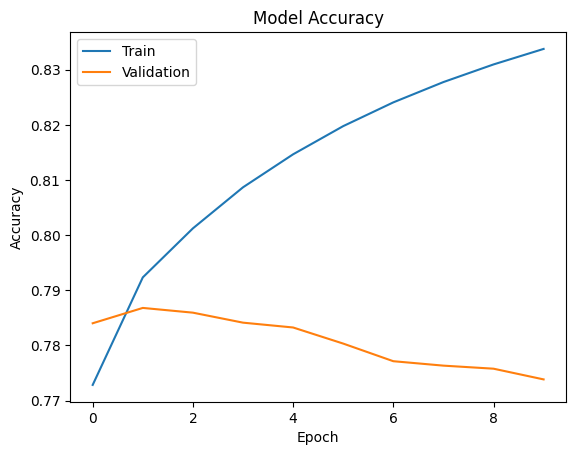


Model 2:
Epoch 1/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 131s 6ms/step - accuracy: 0.5855 - loss: 0.6557 - val_accuracy: 0.6028 - val_loss: 0.6424
Epoch 2/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 123s 6ms/step - accuracy: 0.6087 - loss: 0.6361 - val_accuracy: 0.6030 - val_loss: 0.6433
Epoch 3/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 123s 6ms/step - accuracy: 0.6183 - loss: 0.6243 - val_accuracy: 0.6018 - val_loss: 0.6448
Epoch 4/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 124s 6ms/step - accuracy: 0.6286 - loss: 0.6112 - val_accuracy: 0.5977 - val_loss: 0.6528
Epoch 5/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 123s 6ms/step - accuracy: 0.6358 - loss: 0.5985 - val_accuracy: 0.5964 - val_loss: 0.6652
Epoch 6/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 123s 6ms/step - accuracy: 0.6422 - loss: 0.5872 - val_accuracy: 0.5931 - val_loss: 0.6742
Epoch 7/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 123s 6ms/step - accuracy: 0.6492 - loss: 0.5768 - val_accuracy: 0.5899 - val_loss: 0.6881
Epoch 8/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 123s 6ms

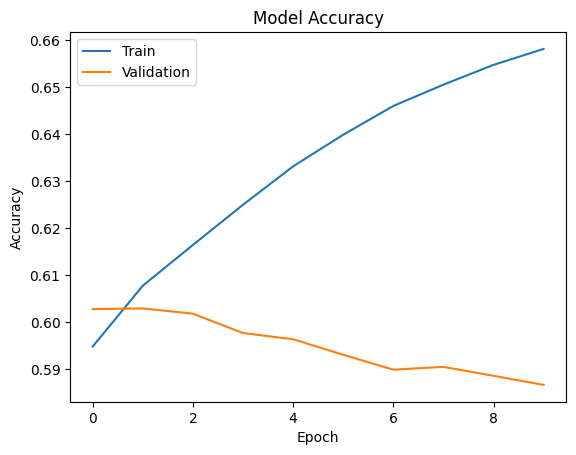


Model 3:
Epoch 1/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 436s 21ms/step - accuracy: 0.7623 - loss: 0.4865 - val_accuracy: 0.7873 - val_loss: 0.4487
Epoch 2/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 426s 21ms/step - accuracy: 0.8006 - loss: 0.4278 - val_accuracy: 0.7831 - val_loss: 0.4534
Epoch 3/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 424s 21ms/step - accuracy: 0.8174 - loss: 0.3976 - val_accuracy: 0.7838 - val_loss: 0.4547
Epoch 4/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 440s 21ms/step - accuracy: 0.8350 - loss: 0.3666 - val_accuracy: 0.7798 - val_loss: 0.4720
Epoch 5/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 420s 21ms/step - accuracy: 0.8520 - loss: 0.3338 - val_accuracy: 0.7726 - val_loss: 0.5061
Epoch 6/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 420s 21ms/step - accuracy: 0.8684 - loss: 0.3017 - val_accuracy: 0.7749 - val_loss: 0.5162
Epoch 7/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 420s 21ms/step - accuracy: 0.8813 - loss: 0.2743 - val_accuracy: 0.7712 - val_loss: 0.5679
Epoch 8/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 4

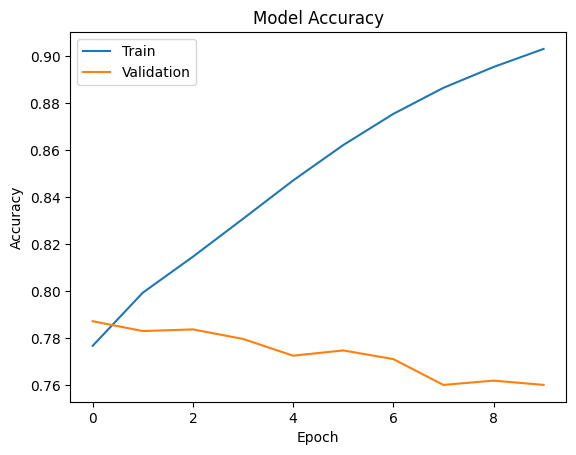


Model 4:
Epoch 1/10
    3/20000 ━━━━━━━━━━━━━━━━━━━━ 15:16 46ms/step - accuracy: 0.5122 - loss: 0.6957  

W0000 00:00:1714628031.199187      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4989 - loss: 0.6932

W0000 00:00:1714628724.924107      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714628726.022133      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 723s 36ms/step - accuracy: 0.4989 - loss: 0.6932 - val_accuracy: 0.4984 - val_loss: 0.6932
Epoch 2/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 708s 35ms/step - accuracy: 0.4998 - loss: 0.6932 - val_accuracy: 0.4984 - val_loss: 0.6932
Epoch 3/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 708s 35ms/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.4984 - val_loss: 0.6933
Epoch 4/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 704s 35ms/step - accuracy: 0.5001 - loss: 0.6932 - val_accuracy: 0.4984 - val_loss: 0.6932
Epoch 5/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 706s 35ms/step - accuracy: 0.4991 - loss: 0.6932 - val_accuracy: 0.5016 - val_loss: 0.6932
Epoch 6/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 703s 35ms/step - accuracy: 0.5009 - loss: 0.6932 - val_accuracy: 0.4984 - val_loss: 0.6932
Epoch 7/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 702s 35ms/step - accuracy: 0.5004 - loss: 0.6932 - val_accuracy: 0.4984 - val_loss: 0.6932
Epoch 8/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 702s 35ms/step - accur

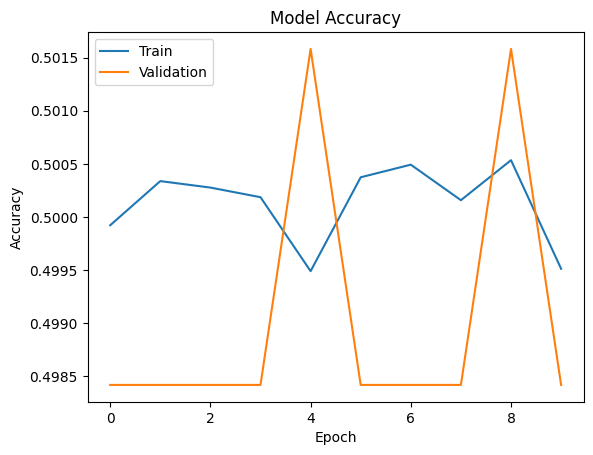

In [21]:
run()